In [1]:
import pymysql
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas, alminer, glob
import matplotlib.pyplot as plt

In [2]:
import astropy.io.fits as pyfits
from matplotlib.patches import Circle
from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion
from regions import RectanglePixelRegion, CircleAnnulusPixelRegion

import os, sys, pymysql, tempfile, sqlcl
from itertools import repeat
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy.ndimage import rotate
from astropy.wcs import WCS

In [17]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
fpath = '/arc/projects/salvage/ALMA_reduction/samples/'
file  =  'pilot_sample.txt'

objID_sample, year_sample, name_sample, muid_sample, guid_sample, auid_sample, proj_sample = np.loadtxt(fpath+file, unpack = True, dtype = str, usecols = [0,11,12,13,14,15,16])
z_sample, mass_sample, rpetro_sample, ra_sample, dec_sample, res_sample, mrs_sample, AL_sample, AC_sample, TP_sample = np.loadtxt(fpath+file, unpack = True, dtype = float, usecols = [1,2,3,4,5,6,7,8,9,10])

# Plot Moments and Extract Masses

In [20]:
def sdss_cutout(objID,band,npix,outdir):

    print('sdss')

    with tempfile.TemporaryDirectory() as wdir:
        # move to working directory defined above
        os.chdir(wdir)
    
        objID = str(objID)
        # first check to see what has already been made in output directory
        gimage_name = outdir+'/'+objID+'_SDSS_'+str(npix)+'x'+str(npix)+'-'+band+'.fits'
        # if this file exists, then the script has already created images for this objID
        if os.access(gimage_name,0):
            return
        
        procflag = -1
        if procflag == -1:
            try:
                # query skyserver for values to avoid table dependencies
                query = ['SELECT p.objID,f.run,f.rerun,f.camcol,f.field,',
                         'f.aa_{b},f.kk_{b},f.airmass_{b},p.colc_{b},p.rowc_{b},'.format(b=band),
                         'f.sky_{b},f.skysig_{b}'.format(b=band),
                         'FROM Field as f JOIN PhotoObjAll as p',
                         'ON (f.run=p.run AND f.rerun=p.rerun AND f.camcol=p.camcol AND f.field=p.field)',
                         'WHERE p.objID = {}'.format(objID)]
                lines = sqlcl.query(str.join(' ',query)).readlines()
                vals = lines[1].decode("utf-8").split('\n')[0].split(',')
                # parse for field and location info
                run = int(vals[1])
                rerun = int(vals[2])
                camcol = int(vals[3])
                field = int(vals[4])
                zeropoint = float(vals[5])
                ext_coeff = float(vals[6])
                airmass = float(vals[7])
                colc = float(vals[8])
                rowc = float(vals[9])
                sky = float(vals[10])*1e9*0.396127**2
                skysig = float(vals[11])*sky*np.log(10)/2.5
                tmp_field = str(field)
                tmp_run = str(run)
                # temporary field and run names for DAS path
                while len(tmp_field) < 4: tmp_field = "0"+tmp_field
                while len(tmp_run) < 6: tmp_run = '0'+tmp_run
            except:
                print('\n Could not locate objID {} on skyserver... continue \n'.format(objID))
                return
    
        
        #############################################
        # must now fetch images from the SDSS server
        # failure --> procflag = 2
        #############################################
        if procflag == -1:
    
            # Path definitions for DR7 DAS
            tmp_run = str(run)
            while len(tmp_run) < 6: tmp_run = '0'+tmp_run
            sdss_path = "imaging/"+str(run)+"/"+str(rerun)+"/objcs/"+str(camcol)+"/"
            sdss_path_c = "imaging/"+str(run)+"/"+str(rerun)+"/corr/"+str(camcol)+"/"
            # SDSS DR7 corrected Image
            corr_name_target = "fpC-"+tmp_run+"-"+band+str(camcol)+"-"+tmp_field+".fit"
            corr_name = "fpC-"+tmp_run+"-"+band+str(camcol)+"-"+tmp_field+"-"+str(objID)+".fit"
            try:
                wgetcmd = 'wget -O '+corr_name+'.gz http://das.sdss.org/'+sdss_path_c+corr_name_target+'.gz'
                os.system(wgetcmd)
                os.system("gunzip "+corr_name+'.gz')
                if not os.access(corr_name,0): procflag = 2
            except:
                raise
                procflag = 2
    
        ############################################
        # build dr7 science image from dr7 corrected image
        # failure --> procflag = 20
        ############################################
        if procflag == -1:
            try:
                sci_xc = int(np.around((npix-1.0)/2.0))
                sci_yc = sci_xc
                sci_nx = npix
                sci_ny = npix
                
                try:
                    corrim = fits.open(corr_name)
                except:
                    raise Exception('Could not open corrected image...')
                
                # image data from corrected image
                corrim_data = corrim[0].data.astype(float)
                # remove softbias
                softbias = float(corrim[0].header['SOFTBIAS'])
                corrim_data -= softbias
                # calibrate to AB nanomaggies
                corrim_data *= 10**(0.4*(zeropoint+ext_coeff*airmass+22.5))/53.907
                # corrected image dimensions
                corrim_nx = corrim[0].header.get('NAXIS1')
                corrim_ny = corrim[0].header.get('NAXIS2')
                # location of galaxy centroid in corrected image
                corrim_xc = int(colc) - 1
                corrim_yc = int(rowc) - 1
                galim = fits.HDUList()
                hdu = fits.PrimaryHDU()
                hdu_data = np.zeros((sci_ny,sci_nx))
                for j in range(sci_ny):
                    for i in range(sci_nx):
                        ii = i - sci_xc + corrim_xc
                        jj = j - sci_yc + corrim_yc
                        if ii >= 0 and ii <= corrim_nx-1 and jj >= 0 and jj <= corrim_ny-1:
                            hdu_data[j,i] = corrim_data[jj,ii]
                        else:
                            hdu_data[j,i] = -9999.99
                
                hdu.data = hdu_data
                # add book-keeping info to output image header
                hdu.header.set('INPUT_IM',corr_name_target,comment='SDSS corrected image')
                hdu.header.set('RUN',run,comment='SDSS Run')
                hdu.header.set('RERUN',rerun,comment='SDSS Rerun')
                hdu.header.set('CAMCOL',camcol,comment='SDSS Camcol')
                hdu.header.set('FIELD',field,comment='SDSS Field')
                hdu.header.set('BAND',band,comment='SDSS Band')
                hdu.header.set('BUNIT','AB nanomaggies',comment='Pixel Units')
                hdu.header.set('SCALE',0.396127,comment='Scale [arcsec/pixel]')
                hdu.header.set('AA',zeropoint,comment='Zeropoint')
                hdu.header.set('KK',ext_coeff,comment='Atm. Extinction Coefficient')
                hdu.header.set('AMASS',airmass,comment='Atm. Airmass')
                hdu.header.set('XCENTER',colc,comment='Object x-position on SDSS corrected image')
                hdu.header.set('YCENTER',rowc,comment='Object y-position on SDSS corrected image')
                hdu.header.set('SKY',sky,comment='Average sky in full SDSS field [nanomaggies]')
                hdu.header.set('SKYSIG',skysig,comment='Average sky uncertainty per pixel [nanomaggies]')
                galim.append(hdu)
                if os.access(gimage_name,0): os.remove(gimage_name)
                galim.writeto(gimage_name)
                corrim.close()
                        
            except:
                raise
                print('\n',procflag,'\n')
                pass
    
        try:
            if os.access(corr_name,0): os.remove(corr_name)
        except:
            os.system('rm fpC*')
            raise Exception('Could not remove corrected image.\n Exiting to avoid problems...\n')


def demo_PHANGS_moments_annuli(imagename, z, r_outer, ID):

    #r_outer = r_outer * 0.396

    try:

        ## load moments
        moment_0 = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_mom0'))
        moment_1 = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_mom1'))
        moment_2 = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_ew'))
        
        header_0 = pyfits.getheader(imagename.replace('MOMENTTYPE', 'strict_mom0'))
        header_1 = pyfits.getheader(imagename.replace('MOMENTTYPE', 'strict_mom1'))
        header_2 = pyfits.getheader(imagename.replace('MOMENTTYPE', 'strict_ew'))
        
    except:
        print(imagename)
        return

    print('\'BMAJ\' from header: ', header_0['BMAJ']*3600)
    
    ## plot moments
    
    Npix = header_0['NAXIS1']
    wpix = 25
    
    min_x, max_x = int(Npix/2 - wpix), int(Npix/2 + wpix)
    min_y, max_y = int(Npix/2 - wpix), int(Npix/2 + wpix)
    
    fig, axes = plt.subplots(1, 3, figsize=(13, 3))

    axes[0].set_title(header_0['BTYPE'], fontsize = 11)
    #contour = axes[0].contour(moment_0[min_x: max_x, min_y: max_y], levels = [KkmsLim], zorder = 10, cmap='Reds')
    #plt.clabel(contour, inline=1, fontsize=10)
    demo_mom0 = moment_0[min_x: max_x, min_y: max_y].copy()
    demo_mom0[demo_mom0<=0] = np.nan
    out = axes[0].imshow(demo_mom0, origin = 'lower', cmap = 'cividis')
    plt.colorbar(out, label=header_0['BUNIT'], shrink = 0.85)

    # plot inner radius
    centre = (wpix,wpix)
    radius = 1.5 / (header_0['CDELT2']*3600)
    circle = Circle(centre, radius, fill = False, color = 'tab:red', lw = 2)
    axes[0].add_patch(circle)

    # plot outer radius
    centre = (wpix,wpix)
    radius_outer = r_outer / (header_0['CDELT2']*3600)
    circle = Circle(centre, radius_outer, fill = False, color = 'tab:pink', lw = 2, ls = '--')
    axes[0].add_patch(circle)

    # plot beam
    centre = (5,5)
    radius_beam = header_0['BMAJ']*3600 / 2 / (header_0['CDELT2']*3600)
    circle = Circle(centre, radius_beam, fill = False, color = 'black', lw = 1.2)
    axes[0].add_patch(circle)
    
    axes[1].set_title(header_1['BTYPE'], fontsize = 11)
    out = axes[1].imshow(moment_1[min_x: max_x, min_y: max_y] - np.nanmedian(moment_1[min_x: max_x, min_y: max_y]), origin = 'lower', cmap = 'coolwarm')
    plt.colorbar(out, label=header_1['BUNIT'], shrink = 0.85)

    axes[2].set_title(header_2['BTYPE'], fontsize = 11)
    out = axes[2].imshow(moment_2[min_x: max_x, min_y: max_y], origin = 'lower', cmap = 'magma')
    plt.colorbar(out, label=header_2['BUNIT'], shrink = 0.85)

    plt.show()

        
    ## calculate MH2
    
    arcsec_per_pix = header_0['CDELT2']*3600 # "/pix
    pc_per_arcsec = (cosmo.arcsec_per_kpc_proper(z=z).value / 1e3) ** -1
    pc_per_pix = pc_per_arcsec * arcsec_per_pix

    L_CO = np.nansum(np.nansum(moment_0 * pc_per_pix**2 ))
    a_CO = 4.35 #(K km s−1 pc2)^−1 # from Lin+20

    M_H2 = L_CO * a_CO
    
    
    ## calculate error on MH2
    
    moment_0_err = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_emom0'))
    #L_CO_err = np.nansum(np.sqrt(np.nansum( (moment_0 * pc_per_pix**2)**2 ) ) / np.sqrt(len(moment_0.flatten())))
    L_CO_err = np.nansum(np.sqrt(np.nansum( (moment_0_err * pc_per_pix**2)**2 ) ))
    M_H2_err = L_CO_err * a_CO
    
    #print('log(MH2) = ', np.log10(M_H2), ' +/- ', np.log10(M_H2_err))
    print(f'log(MH2) = {np.log10(M_H2): .5f} +/- {np.log10(M_H2) - np.log10(M_H2 - M_H2_err): .5f}')
    #print('log(MH2) = ', np.log10(M_H2), ' +/- ', np.log10(M_H2 + M_H2_err) - np.log10(M_H2))
    
    
    
    ## calculate MH2 (inner)
    
    center = PixCoord(wpix,wpix)
    radius = 1.5 / (header_0['CDELT2']*3600)
    aperture = CirclePixelRegion(center, radius)
    
    mask = aperture.to_mask(mode='exact')
    moment_0_inner = mask.multiply(moment_0[min_x: max_x, min_y: max_y])
    moment_0_inner_err = mask.multiply(moment_0_err[min_x: max_x, min_y: max_y])

    L_CO_inner = np.nansum(np.nansum(moment_0_inner * pc_per_pix**2 ))
    L_CO_inner_err = np.nansum(np.sqrt(np.nansum( (moment_0_inner_err * pc_per_pix**2)**2 ) ))
    
    a_CO = 4.35 #(K km s−1 pc2)^−1 # from Lin+20

    M_H2_inner = L_CO_inner * a_CO
    M_H2_inner_err = L_CO_inner_err * a_CO
    
    print(f'log(MH2) (inner) = {np.log10(M_H2_inner): .5f} +/- {np.log10(M_H2_inner) - np.log10(M_H2_inner - M_H2_inner_err): .5f}')


    ## calculate MH2 (outer)
    
    center = PixCoord(wpix,wpix)
    radius_inner = 1.5 / (header_0['CDELT2']*3600)
    radius_outer = r_outer / (header_0['CDELT2']*3600)
    #aperture = CircleAnnulusPixelRegion(center, radius_inner, radius_outer)
    aperture = CirclePixelRegion(center, radius_outer)

    mask_outer = aperture.to_mask()
    #boolean defeats the purpose of half values
    #mask_outer = np.array(mask_outer.to_image(np.shape(moment_0[min_x: max_x, min_y: max_y])).data, dtype = 'bool') & (~np.array(mask.to_image(np.shape(moment_0[min_x: max_x, min_y: max_y])).data, dtype = 'bool'))
    mask_outer = np.array(mask_outer.to_image(np.shape(moment_0[min_x: max_x, min_y: max_y])).data, dtype = float) - np.array(mask.to_image(np.shape(moment_0[min_x: max_x, min_y: max_y])).data, dtype = float)
    
    #moment_0_outer = mask_outer.multiply(moment_0[min_x: max_x, min_y: max_y])
    #moment_0_outer_err = mask_outer.multiply(moment_0_err[min_x: max_x, min_y: max_y])
    moment_0_outer = mask_outer * moment_0[min_x: max_x, min_y: max_y]
    moment_0_outer_err = mask_outer * moment_0_err[min_x: max_x, min_y: max_y]

    L_CO_outer = np.nansum(np.nansum(moment_0_outer * pc_per_pix**2 ))
    L_CO_outer_err = np.nansum(np.sqrt(np.nansum( (moment_0_outer_err * pc_per_pix**2)**2 ) ))
    
    a_CO = 4.35 #(K km s−1 pc2)^−1 # from Lin+20

    M_H2_outer = L_CO_outer * a_CO
    M_H2_outer_err = L_CO_outer_err * a_CO
    
    print(f'log(MH2) (outer) = {np.log10(M_H2_outer): .5f} +/- {np.log10(M_H2_outer) - np.log10(M_H2_outer - M_H2_outer_err): .5f}')

    print(f'log(MH2) (inner+outer) = {np.log10(M_H2_inner + M_H2_outer): .5f}')

    plt.figure(figsize = (3,3))
    plt.title('Outer Mask')
    plt.imshow(mask_outer, origin = 'lower')
    plt.show()

    # output to file
    out = open('/arc/projects/salvage/ALMA_reduction/gas_mass.txt', 'a')
    out.write(f'{ID} {np.log10(M_H2)} {np.log10(M_H2_err)} {np.log10(M_H2_inner)} {np.log10(M_H2_inner_err)} {np.log10(M_H2_outer)} {np.log10(M_H2_outer_err)}\n')
    out.close()
    
    return

def view_image(z, i):

    # sdss image

    sdss_fpath = '/arc/projects/salvage/SDSS_images/'
    #npix = int(25*(header_0['CDELT2']*3600/0.396))
    npix = int(50 / 0.396) # 50" x 50" in pix)

    if not os.path.isfile(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits'):
    
        sdss_cutout(i, 'r', npix, sdss_fpath)
        
        with fits.open(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits', mode='update') as hdul:
            hdul[0].data -= hdul[0].header['SKY']
            hdul[0].data[hdul[0].data<-500] = 0.0
            hdul.flush()
            
    sdss = fits.getdata(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits')
    wcs_sdss = WCS(fits.getheader(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits'))

    sdss = rotate(sdss, -90)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.set_title(f'SDSS Image ({i})', fontsize = 11)
    NORM = LogNorm(vmin=np.percentile(sdss[sdss>0], 1),vmax=np.percentile(sdss[sdss>0], 99.99))
    out = ax.imshow(sdss, origin = 'lower', cmap = 'gray_r', norm = NORM)

    #plt.savefig(f'fancy_image_{z}.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
    return

def demo_moments_on_image(imagename, z, i, r_outer):

    try:

        ## load moments
        moment_0 = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_mom0'))
        moment_1 = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_mom1'))
        moment_2 = pyfits.getdata(imagename.replace('MOMENTTYPE', 'strict_ew'))
        
        header_0 = pyfits.getheader(imagename.replace('MOMENTTYPE', 'strict_mom0'))
        header_1 = pyfits.getheader(imagename.replace('MOMENTTYPE', 'strict_mom1'))
        header_2 = pyfits.getheader(imagename.replace('MOMENTTYPE', 'strict_ew'))
        
    except:
        print(imagename)
        return
    
    wcs = WCS(header_0)


    # sdss image

    sdss_fpath = '/arc/projects/salvage/SDSS_images/'
    #npix = int(25*(header_0['CDELT2']*3600/0.396))
    npix = int(50 / 0.396) # 50" x 50" in pix)

    if not os.path.isfile(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits'):
    
        sdss_cutout(i, 'r', npix, sdss_fpath)
        
        with fits.open(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits', mode='update') as hdul:
            hdul[0].data -= hdul[0].header['SKY']
            hdul[0].data[hdul[0].data<-500] = 0.0
            hdul.flush()
            
    sdss = fits.getdata(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits')
    wcs_sdss = WCS(fits.getheader(sdss_fpath + i + f'_SDSS_{npix}x{npix}-r.fits'))

    sdss = rotate(sdss, -90)
    
    
    ## plot moments
    
    Npix = header_0['NAXIS1']
    wpix = int(25 / (header_0['CDELT2']*3600)) # 20" x 20" in pix)
    
    min_x, max_x = int(Npix/2 - wpix), int(Npix/2 + wpix)
    min_y, max_y = int(Npix/2 - wpix), int(Npix/2 + wpix)
    '''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    ax.set_title('CO(1-0) Flux', fontsize = 11)
    #contour = axes[0].contour(moment_0[min_x: max_x, min_y: max_y], levels = [KkmsLim], zorder = 10, cmap='Reds')
    #plt.clabel(contour, inline=1, fontsize=10)
    out = ax.imshow(moment_0[min_x: max_x, min_y: max_y], origin = 'lower', cmap = 'gray_r')
    plt.colorbar(out, label=header_0['BUNIT'], shrink = 0.85)
    
    centre = (wpix,wpix)
    radius_outer = r_outer / (header_0['CDELT2']*3600)
    circle = Circle(centre, radius_outer, fill = False, color = 'tab:green')
    ax.add_patch(circle)
    
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec.')

    #plt.savefig(f'fancy_image_{z}.png', bbox_inches = 'tight', dpi = 200)
    plt.show()

    print(wpix)
    '''
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

    ax.set_title('SDSS Image', fontsize = 11)
    #contour = ax.contour(moment_0[min_x: max_x, min_y: max_y], levels = 15, zorder = 10, cmap='Reds', alpha = 0.5)
    contour = ax.contour(moment_0[min_x: max_x, min_y: max_y], levels = 5, zorder = 10, cmap='YlOrRd', alpha = 0.5, linewidths = 2)
    #plt.clabel(contour, inline=1, fontsize=10)
    NORM = LogNorm(vmin=np.percentile(sdss[sdss>0], 1),vmax=np.percentile(sdss[sdss>0], 99.99))
    out = ax.imshow(sdss, origin = 'lower', cmap = 'gray_r', extent = (0, 2*wpix, 0, 2*wpix), norm = NORM)
    #plt.colorbar(out, shrink = 0.85)

    centre = (wpix,wpix)
    radius_outer = r_outer / (header_0['CDELT2']*3600)
    circle = Circle(centre, radius_outer, fill = False, color = 'tab:pink', lw = 2, ls = '--')
    ax.add_patch(circle)

    #plt.savefig(f'fancy_image_{z}.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
    return

587731173842027508
'resolution' from archive:  2.403678099584942
'BMAJ' from header:  3.1495656851838


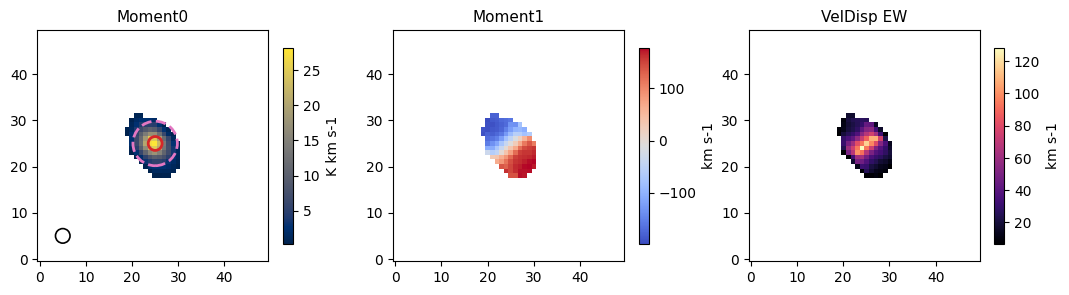

log(MH2) =  10.03279 +/-  0.00266
log(MH2) (inner) =  9.38391 +/-  0.00259
log(MH2) (outer) =  9.86735 +/-  0.00188
log(MH2) (inner+outer) =  9.99072


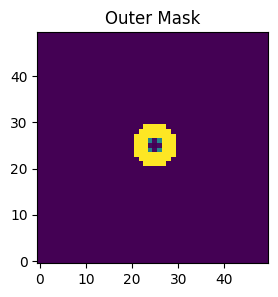

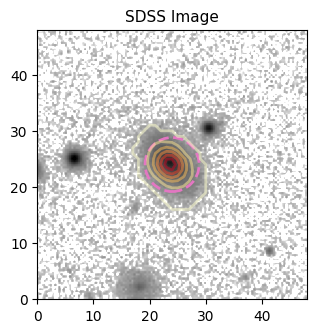

587731173842027508
'resolution' from archive:  2.4083466473482433
'BMAJ' from header:  3.1495656851838


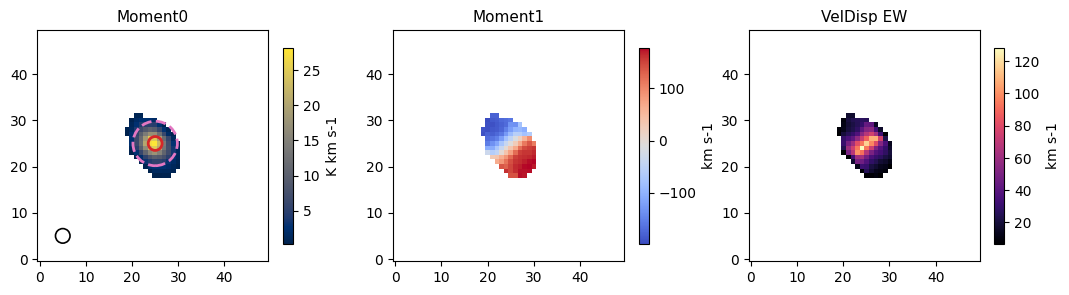

log(MH2) =  10.03279 +/-  0.00266
log(MH2) (inner) =  9.38391 +/-  0.00259
log(MH2) (outer) =  9.86735 +/-  0.00188
log(MH2) (inner+outer) =  9.99072


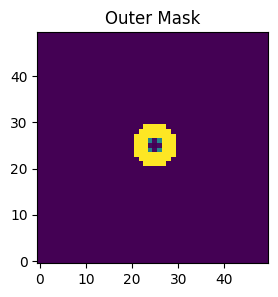

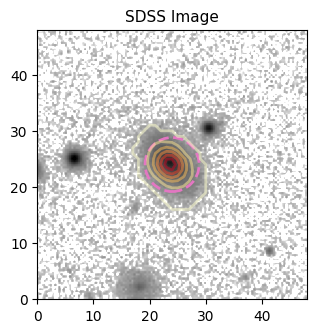

587731185665638418
'resolution' from archive:  1.5853097982691273
'BMAJ' from header:  2.02479435597348


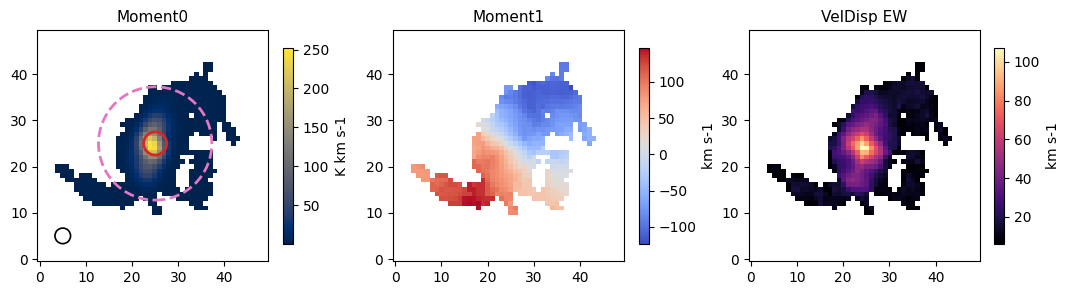

log(MH2) =  10.45238 +/-  0.00066
log(MH2) (inner) =  9.99333 +/-  0.00042
log(MH2) (outer) =  10.24267 +/-  0.00053
log(MH2) (inner+outer) =  10.43668


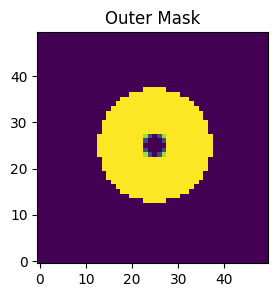

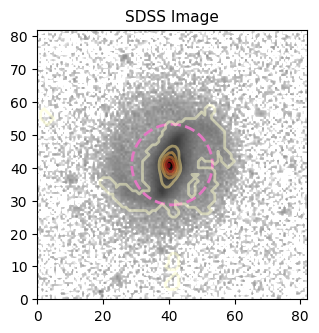

587726033309335775
'resolution' from archive:  1.7668940625365321
'BMAJ' from header:  2.5571972753442003


/arc/home/swilkinson/.conda/envs/almaredux/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


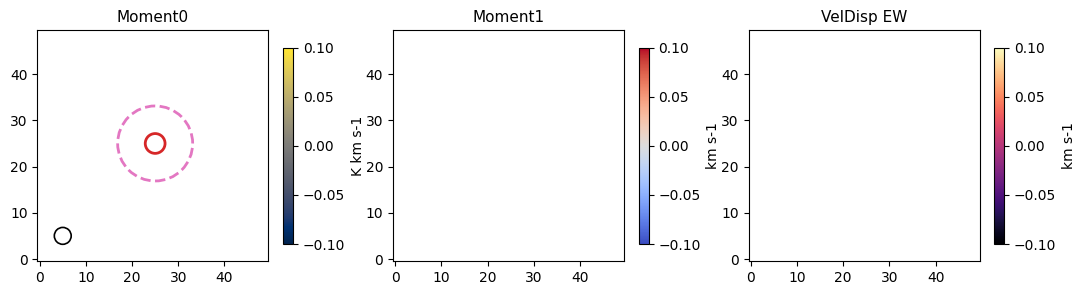

/tmp/ipykernel_368/952680374.py:236: RuntimeWarning: divide by zero encountered in log10
  print(f'log(MH2) = {np.log10(M_H2): .5f} +/- {np.log10(M_H2) - np.log10(M_H2 - M_H2_err): .5f}')
/tmp/ipykernel_368/952680374.py:236: RuntimeWarning: invalid value encountered in log10
  print(f'log(MH2) = {np.log10(M_H2): .5f} +/- {np.log10(M_H2) - np.log10(M_H2 - M_H2_err): .5f}')
/tmp/ipykernel_368/952680374.py:259: RuntimeWarning: divide by zero encountered in log10
  print(f'log(MH2) (inner) = {np.log10(M_H2_inner): .5f} +/- {np.log10(M_H2_inner) - np.log10(M_H2_inner - M_H2_inner_err): .5f}')
/tmp/ipykernel_368/952680374.py:259: RuntimeWarning: invalid value encountered in scalar subtract
  print(f'log(MH2) (inner) = {np.log10(M_H2_inner): .5f} +/- {np.log10(M_H2_inner) - np.log10(M_H2_inner - M_H2_inner_err): .5f}')
/tmp/ipykernel_368/952680374.py:288: RuntimeWarning: divide by zero encountered in log10
  print(f'log(MH2) (outer) = {np.log10(M_H2_outer): .5f} +/- {np.log10(M_H2_outer) - np

log(MH2) = -inf +/-  nan
log(MH2) (inner) = -inf +/-  nan
log(MH2) (outer) = -inf +/-  nan
log(MH2) (inner+outer) = -inf


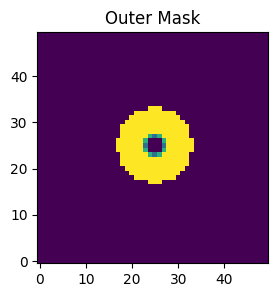

/tmp/ipykernel_368/952680374.py:299: RuntimeWarning: divide by zero encountered in log10
  out.write(f'{ID} {np.log10(M_H2)} {np.log10(M_H2_err)} {np.log10(M_H2_inner)} {np.log10(M_H2_inner_err)} {np.log10(M_H2_outer)} {np.log10(M_H2_outer_err)}\n')
/arc/home/swilkinson/.conda/envs/almaredux/lib/python3.8/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/arc/home/swilkinson/.conda/envs/almaredux/lib/python3.8/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


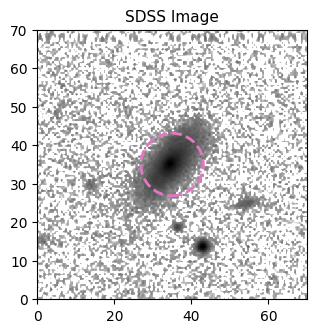

587726032772333771
'resolution' from archive:  1.0182688262545563
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587726032772333771/587726032772333771_12m_co10_MOMENTTYPE.fits
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587726032772333771/587726032772333771_12m_co10_MOMENTTYPE.fits
587727944033960150
'resolution' from archive:  1.0392029153837377
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944033960150/587727944033960150_12m_co10_MOMENTTYPE.fits
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944033960150/587727944033960150_12m_co10_MOMENTTYPE.fits
587731511545626673
'resolution' from archive:  1.615997542467007
'BMAJ' from header:  2.13456043273248


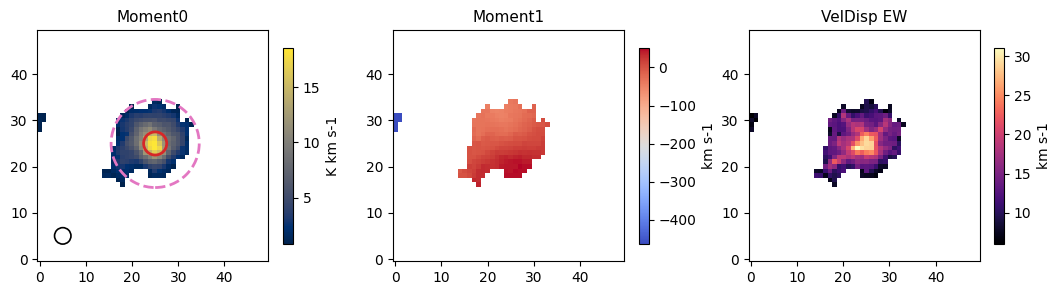

log(MH2) =  9.32430 +/-  0.00808
log(MH2) (inner) =  8.71433 +/-  0.00414
log(MH2) (outer) =  9.18640 +/-  0.00319
log(MH2) (inner+outer) =  9.31261


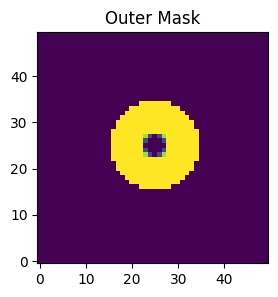

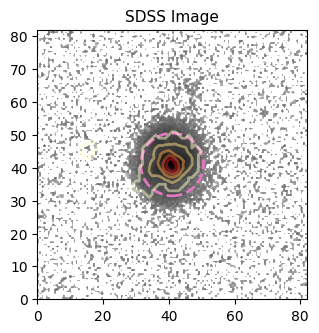

587731187797393472
'resolution' from archive:  2.51668200454541
'BMAJ' from header:  2.76982960765608


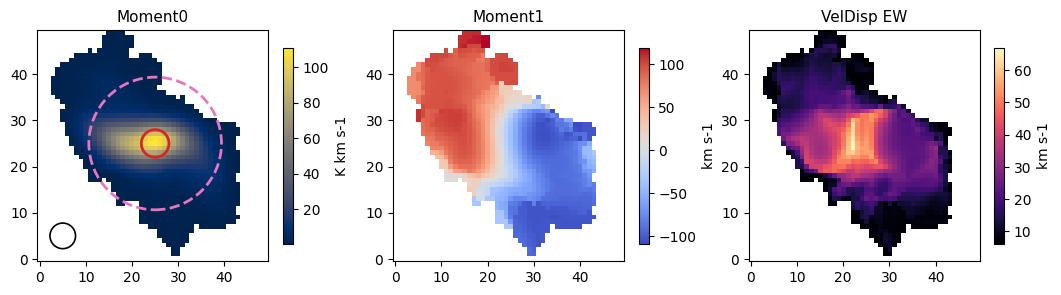

log(MH2) =  9.34584 +/-  0.00043
log(MH2) (inner) =  8.59728 +/-  0.00040
log(MH2) (outer) =  9.21501 +/-  0.00033
log(MH2) (inner+outer) =  9.30883


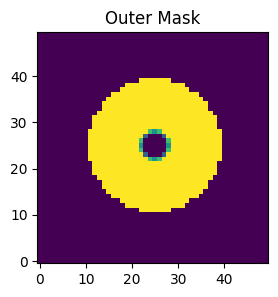

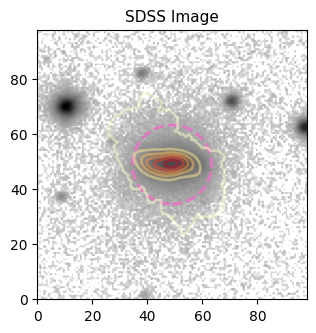

587731511542022280
'resolution' from archive:  2.4497632033217625
'BMAJ' from header:  2.71276505890524


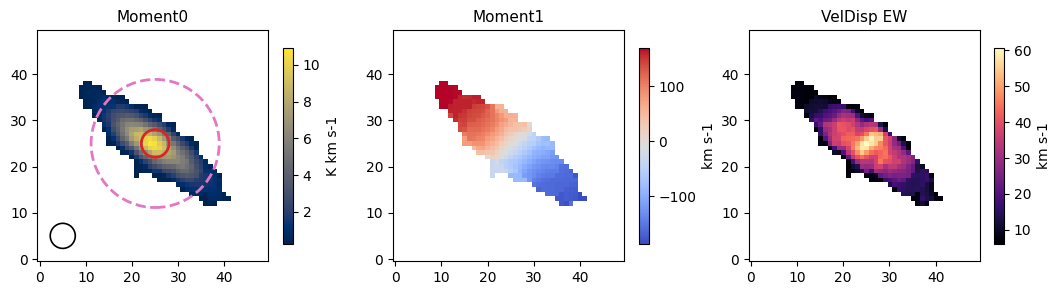

log(MH2) =  8.90497 +/-  0.00357
log(MH2) (inner) =  8.27893 +/-  0.00264
log(MH2) (outer) =  8.76084 +/-  0.00188
log(MH2) (inner+outer) =  8.88459


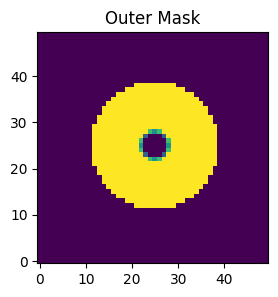

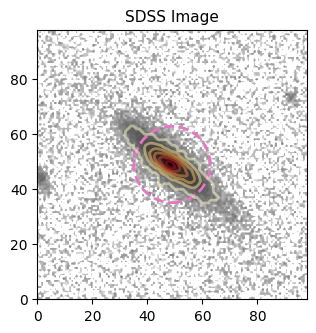

588010359075700997
'resolution' from archive:  2.540573931487716
'BMAJ' from header:  19.0839293452872


/arc/home/swilkinson/.conda/envs/almaredux/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


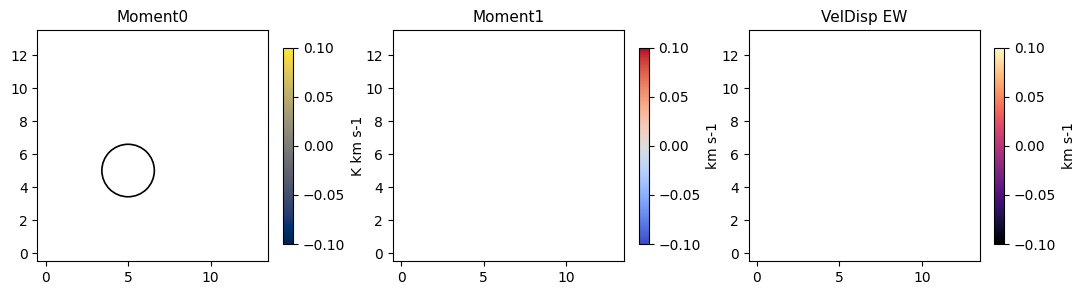

/tmp/ipykernel_368/952680374.py:236: RuntimeWarning: divide by zero encountered in log10
  print(f'log(MH2) = {np.log10(M_H2): .5f} +/- {np.log10(M_H2) - np.log10(M_H2 - M_H2_err): .5f}')
/tmp/ipykernel_368/952680374.py:236: RuntimeWarning: invalid value encountered in log10
  print(f'log(MH2) = {np.log10(M_H2): .5f} +/- {np.log10(M_H2) - np.log10(M_H2 - M_H2_err): .5f}')


log(MH2) = -inf +/-  nan
failed moment


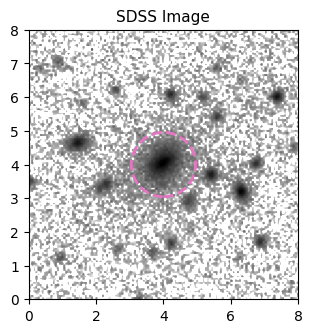

588010359075700997
'resolution' from archive:  11.812000235302849
'BMAJ' from header:  19.0839293452872


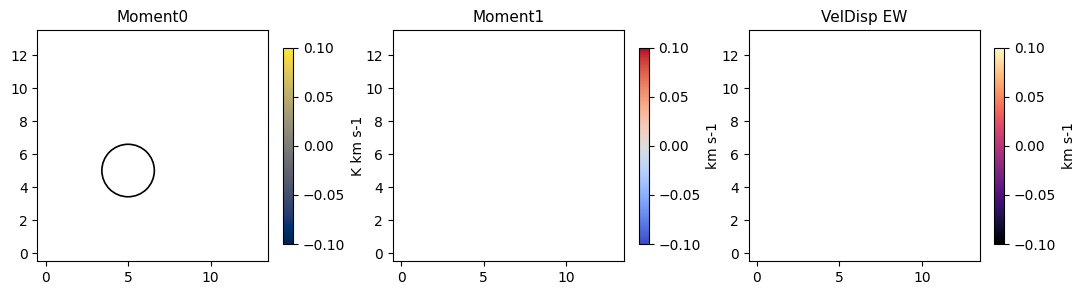

log(MH2) = -inf +/-  nan
failed moment


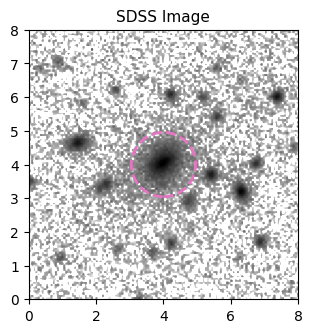

588010359075700997
'resolution' from archive:  0.24300453971179042
'BMAJ' from header:  19.0839293452872


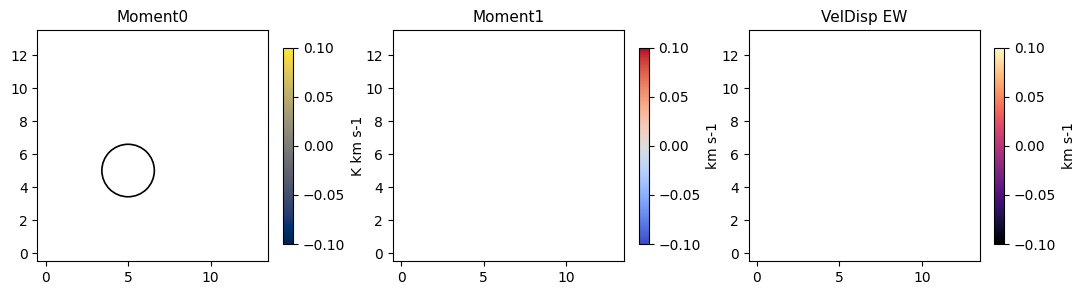

log(MH2) = -inf +/-  nan
failed moment


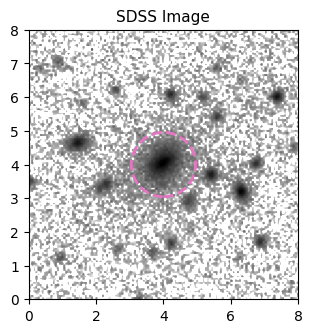

588015508731723912
'resolution' from archive:  1.5748964507357512
'BMAJ' from header:  2.0157814235736


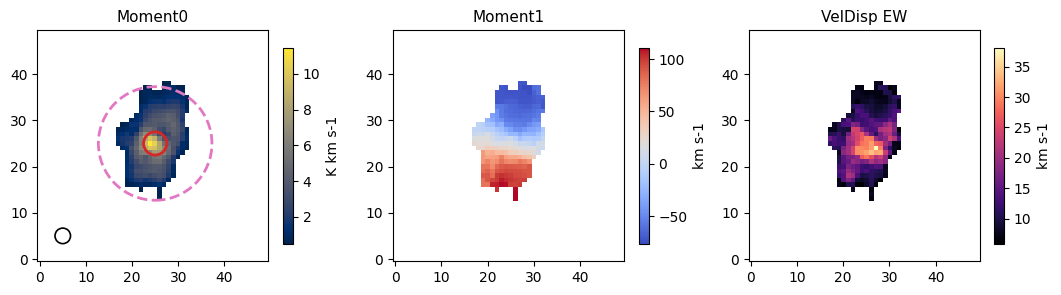

log(MH2) =  8.97805 +/-  0.00709
log(MH2) (inner) =  8.27178 +/-  0.00480
log(MH2) (outer) =  8.87942 +/-  0.00297
log(MH2) (inner+outer) =  8.97522


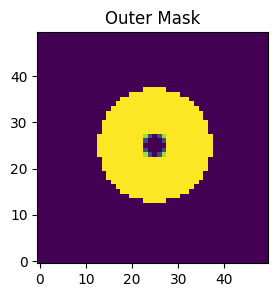

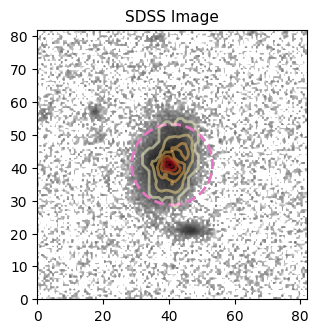

587731512619696292
'resolution' from archive:  2.191923953763737
'BMAJ' from header:  2.45256668927352


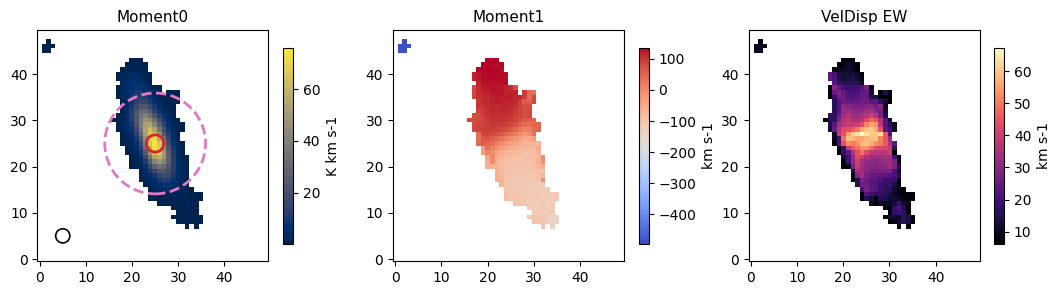

log(MH2) =  9.36832 +/-  0.00066
log(MH2) (inner) =  8.57816 +/-  0.00073
log(MH2) (outer) =  9.25736 +/-  0.00052
log(MH2) (inner+outer) =  9.33990


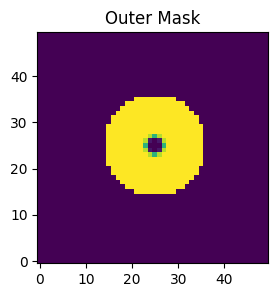

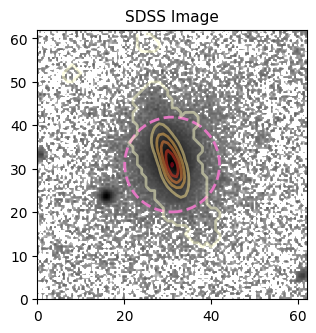

587741490891325518
'resolution' from archive:  1.8028751112752779
'BMAJ' from header:  2.2280810023746


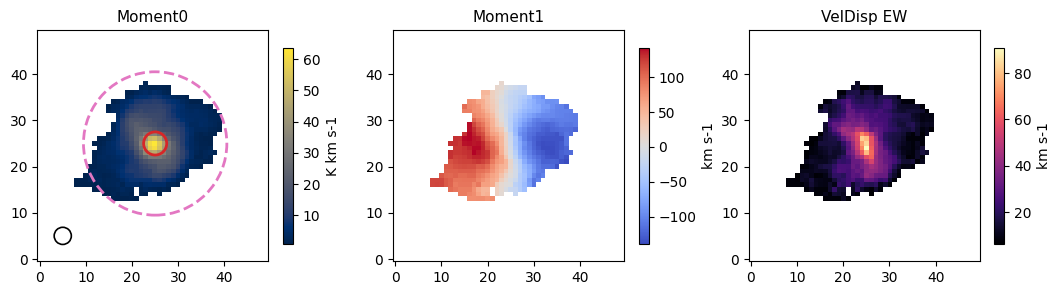

log(MH2) =  10.10083 +/-  0.00214
log(MH2) (inner) =  9.36839 +/-  0.00218
log(MH2) (outer) =  10.00456 +/-  0.00139
log(MH2) (inner+outer) =  10.09486


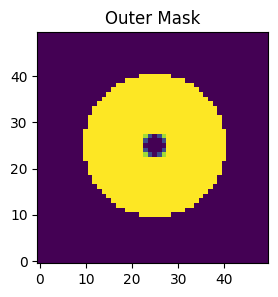

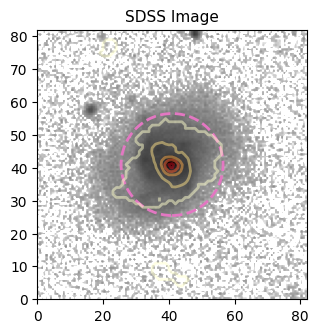

587726033335550094
'resolution' from archive:  11.237323761048643
'BMAJ' from header:  3.4935005005632003


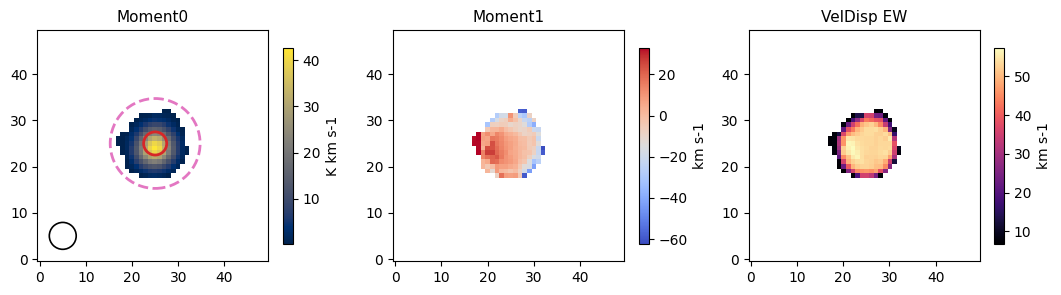

log(MH2) =  10.64403 +/-  0.00179
log(MH2) (inner) =  10.19363 +/-  0.00099
log(MH2) (outer) =  10.45394 +/-  0.00112
log(MH2) (inner+outer) =  10.64403


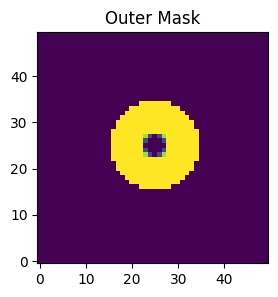

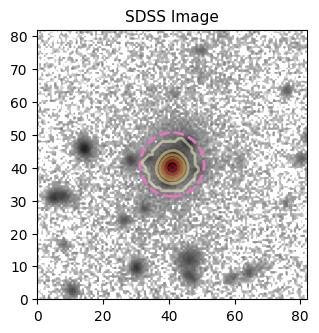

587726033335550094
'resolution' from archive:  2.8058388401522274
'BMAJ' from header:  3.4935005005632003


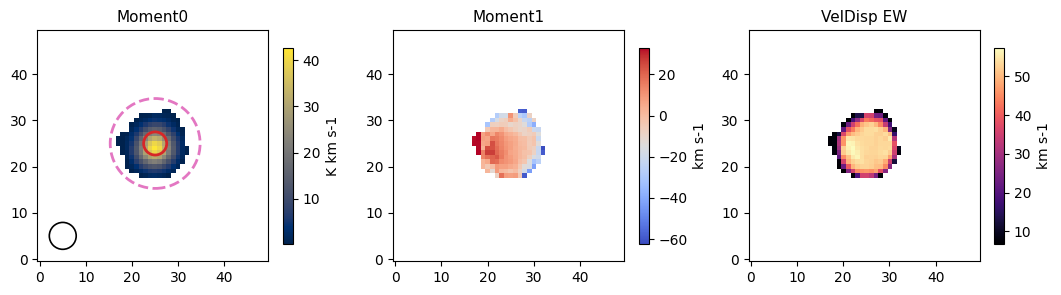

log(MH2) =  10.64403 +/-  0.00179
log(MH2) (inner) =  10.19363 +/-  0.00099
log(MH2) (outer) =  10.45394 +/-  0.00112
log(MH2) (inner+outer) =  10.64403


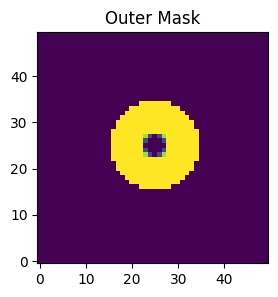

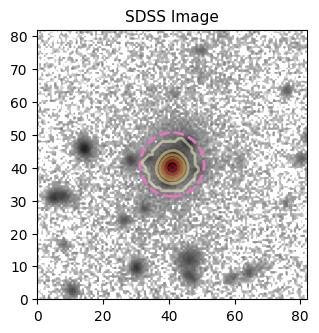

587727221402042402
'resolution' from archive:  1.7069609083631339
'BMAJ' from header:  1.8892491098191198


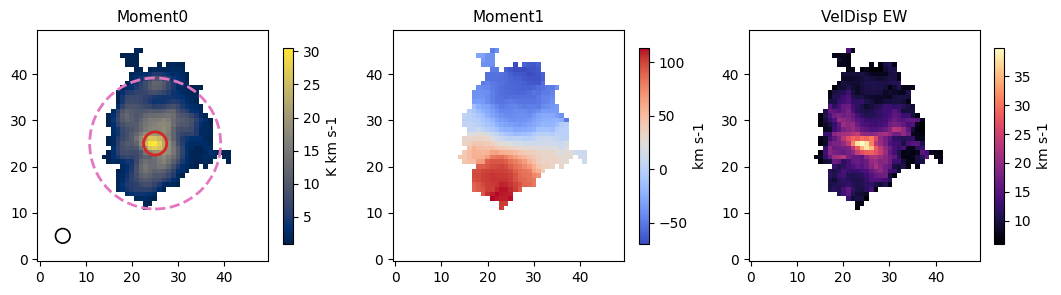

log(MH2) =  9.27333 +/-  0.00261
log(MH2) (inner) =  8.35160 +/-  0.00281
log(MH2) (outer) =  9.19971 +/-  0.00134
log(MH2) (inner+outer) =  9.25733


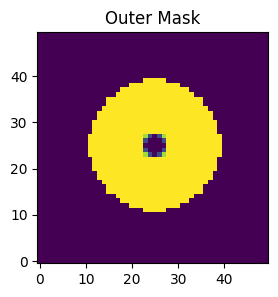

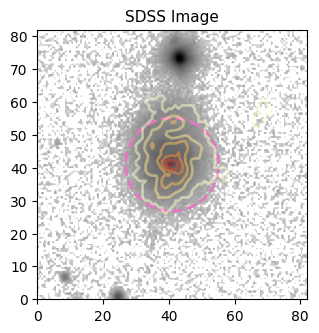

587727221396013696
'resolution' from archive:  2.567323736319498
'BMAJ' from header:  2.9382456711744003


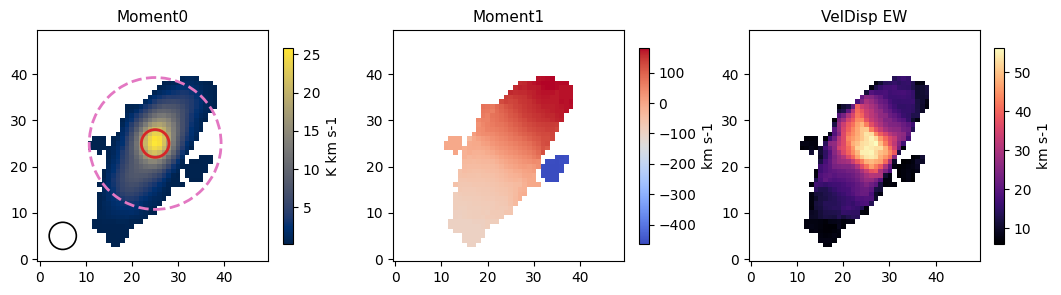

log(MH2) =  9.34440 +/-  0.00140
log(MH2) (inner) =  8.68015 +/-  0.00105
log(MH2) (outer) =  9.21600 +/-  0.00084
log(MH2) (inner+outer) =  9.32698


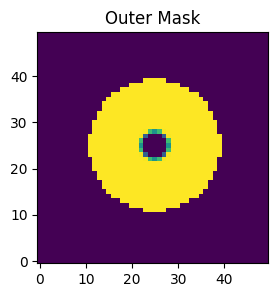

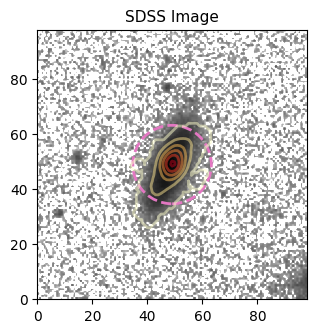

587727944034091201
'resolution' from archive:  1.7677543117417982
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944034091201/587727944034091201_12m_co10_MOMENTTYPE.fits
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944034091201/587727944034091201_12m_co10_MOMENTTYPE.fits
587727944034091092
'resolution' from archive:  1.7655891361098615
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944034091092/587727944034091092_12m_co10_MOMENTTYPE.fits
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944034091092/587727944034091092_12m_co10_MOMENTTYPE.fits
587727944034091239
'resolution' from archive:  1.7649338413075926
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944034091239/587727944034091239_12m_co10_MOMENTTYPE.fits
/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/587727944034091239/587727944034091239_12m_co10_MOMENTTYPE.fits
588015510364880957
'resolution' from archive:  2.597491008

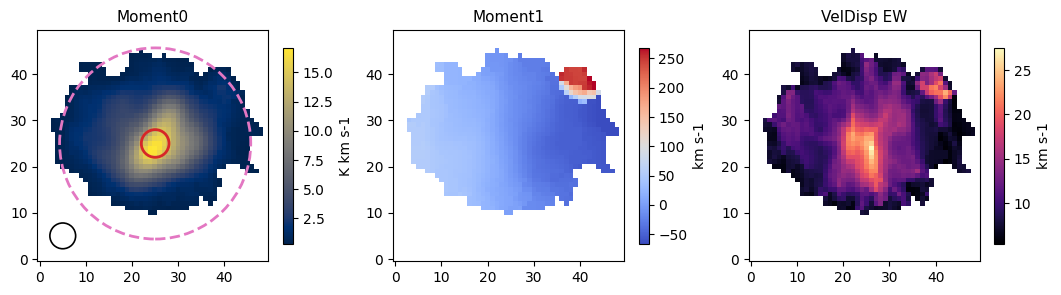

log(MH2) =  8.99167 +/-  0.00110
log(MH2) (inner) =  8.03609 +/-  0.00109
log(MH2) (outer) =  8.93705 +/-  0.00065
log(MH2) (inner+outer) =  8.98844


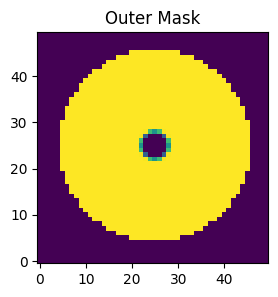

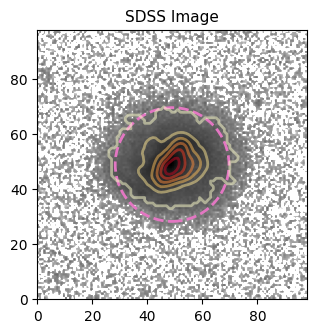

587741421099155681
'resolution' from archive:  1.7352597831283654
'BMAJ' from header:  1.91995675180308


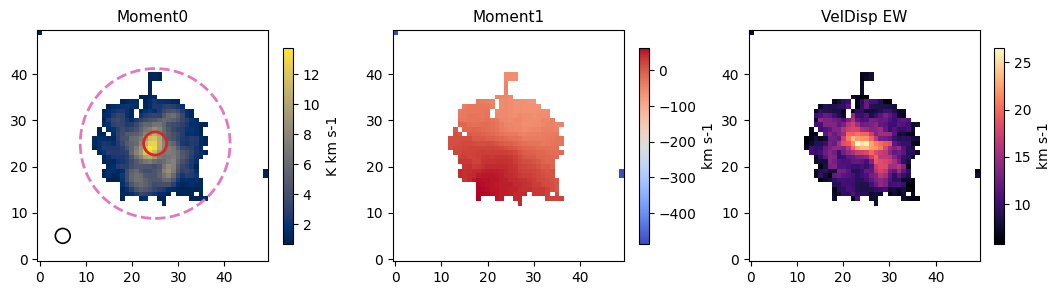

log(MH2) =  8.94697 +/-  0.00480
log(MH2) (inner) =  8.04185 +/-  0.00426
log(MH2) (outer) =  8.87630 +/-  0.00232
log(MH2) (inner+outer) =  8.93564


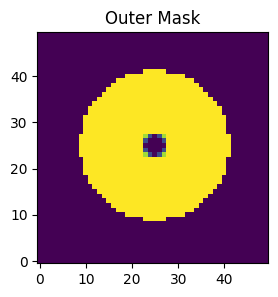

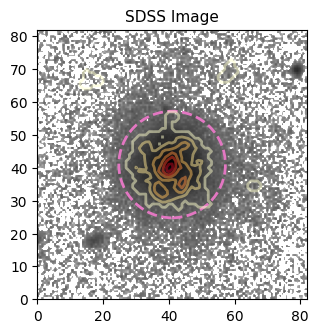

587742060530696249
'resolution' from archive:  1.8002183168772599
'BMAJ' from header:  1.85759901985788


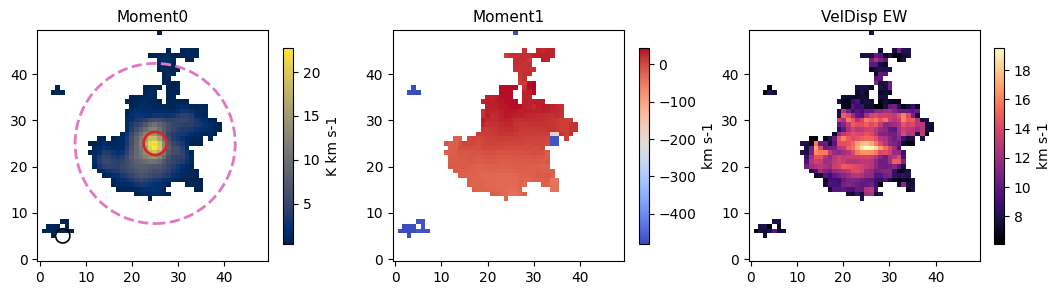

log(MH2) =  9.29591 +/-  0.00324
log(MH2) (inner) =  8.55634 +/-  0.00182
log(MH2) (outer) =  9.19424 +/-  0.00174
log(MH2) (inner+outer) =  9.28421


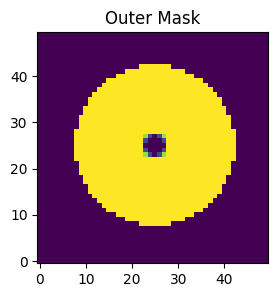

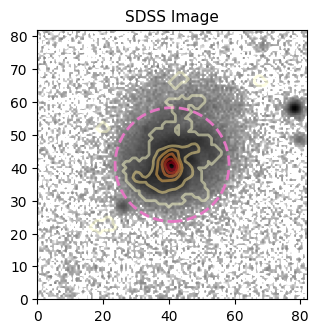

587731186187632690
'resolution' from archive:  2.52469841219766
'BMAJ' from header:  2.6882171723419197


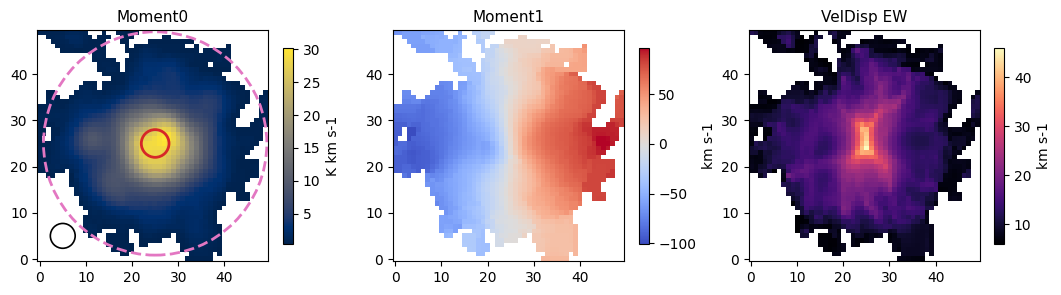

log(MH2) =  9.56498 +/-  0.00059
log(MH2) (inner) =  8.50223 +/-  0.00091
log(MH2) (outer) =  9.51249 +/-  0.00043
log(MH2) (inner+outer) =  9.55296


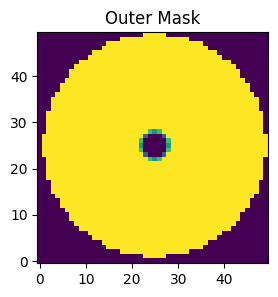

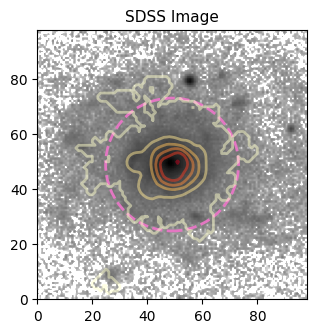

In [21]:
# wipe file
out = open('/arc/projects/salvage/ALMA_reduction/gas_mass.txt', 'w')
out.write('#objID M_H2 M_H2_err M_H2_inner M_H2_inner_err M_H2_outer M_H2_outer_err\n')
out.close()

for i in range(len(objID_sample)):

    ID = objID_sample[i]
    NAME = name_sample[i]
    Z = z_sample[i]
    M = mass_sample[i]
    R = rpetro_sample[i]

    print(ID)
    print('\'resolution\' from archive: ', res_sample[i])

    imagename = f'/arc/projects/salvage/ALMA_reduction/phangs_pipeline/derived/{ID}/{ID}_12m_co10_MOMENTTYPE.fits'

    try:
        demo_PHANGS_moments_annuli(imagename, Z, 2*R, ID)
    except:
        print('failed moment')

    #view_image(Z, ID)

    try:
        demo_moments_on_image(imagename, Z, ID, 2*R)
    except:
        print('failed image')

In [7]:
objID_gas = np.loadtxt('/arc/projects/salvage/ALMA_reduction/gas_mass.txt', unpack = True, usecols = [0], dtype = 'str')
M_H2, M_H2_err, M_H2_inner, M_H2_inner_err, M_H2_outer, M_H2_outer_err = np.loadtxt('/arc/projects/salvage/ALMA_reduction/gas_mass.txt', unpack = True, usecols = [1,2,3,4,5,6])

/tmp/ipykernel_368/643716906.py:1: UserWarning: loadtxt: input contained no data: "/arc/projects/salvage/ALMA_reduction/gas_mass.txt"
  objID_gas = np.loadtxt('/arc/projects/salvage/ALMA_reduction/gas_mass.txt', unpack = True, usecols = [0], dtype = 'str')
/tmp/ipykernel_368/643716906.py:2: UserWarning: loadtxt: input contained no data: "/arc/projects/salvage/ALMA_reduction/gas_mass.txt"
  M_H2, M_H2_err, M_H2_inner, M_H2_inner_err, M_H2_outer, M_H2_outer_err = np.loadtxt('/arc/projects/salvage/ALMA_reduction/gas_mass.txt', unpack = True, usecols = [1,2,3,4,5,6])


In [8]:
#Query MySQL for SDSS ancillary data

db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT u.objID, u.ra, u.decl, u.total_mass_med, u.z_spec, u.petroR50_r, u.total_sfr_med, u.fiber_mass_med, u.fiber_sfr_med FROM  dr7_uberuber u WHERE u.total_mass_med > 1 AND u.z_spec < 0.5 AND u.decl < 47'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()
	
# transpose queried table
data = np.array(db_data, dtype = float).T
table_id = np.array(db_data, dtype = str).T[0]

ra_sdss = data[1]
dec_sdss = data[2]
mass_sdss = data[3]
z_sdss = data[4]
rpetro_sdss = data[5]
sfr_sdss = data[6]
fib_mass_sdss = data[7]
fib_sfr_sdss = data[8]

In [9]:
match, table_idx, gas_idx = np.intersect1d(table_id, objID_gas, return_indices = True)
len(match)

0

In [10]:
fgas_inner = 10**M_H2_inner[gas_idx] / 10**fib_mass_sdss[table_idx]
fgas_outer = 10**M_H2_outer[gas_idx] / (10**mass_sdss[table_idx] - 10**fib_mass_sdss[table_idx])
fgas_grad = fgas_inner/ fgas_outer

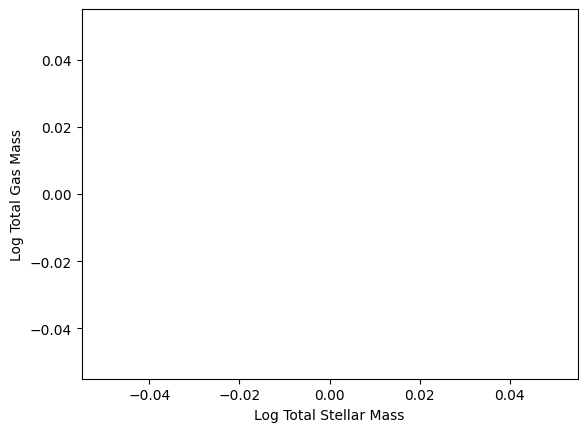

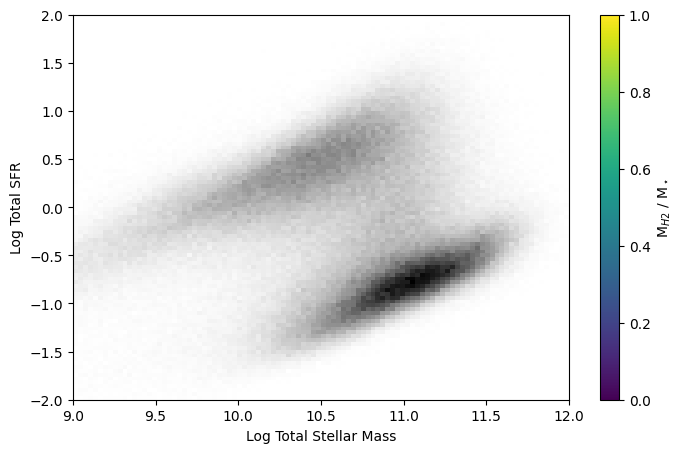

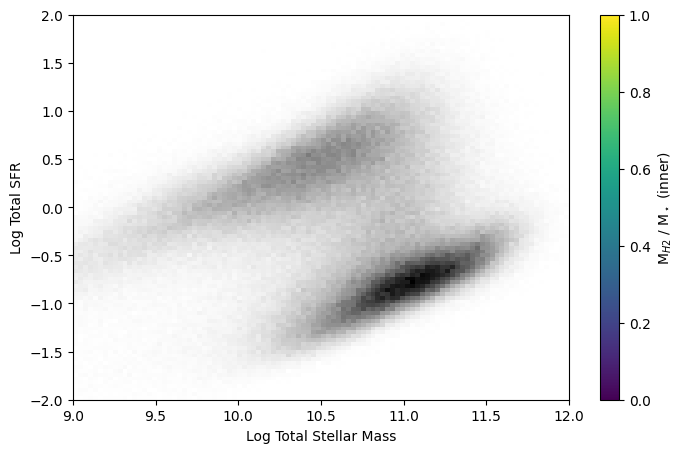

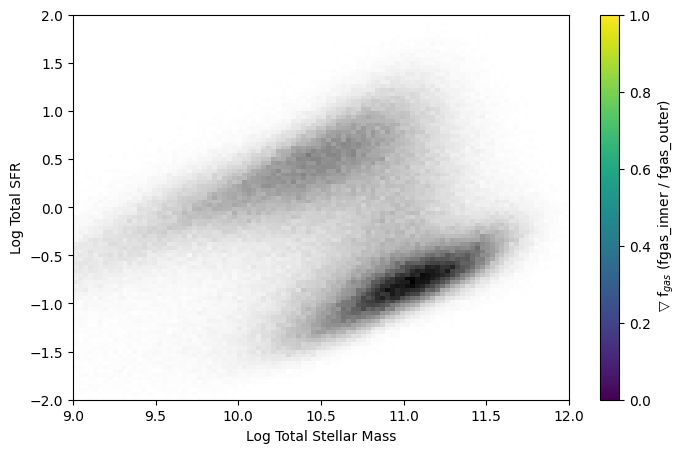

In [11]:
plt.figure()
plt.scatter(mass_sdss[table_idx], M_H2[gas_idx])
plt.xlabel('Log Total Stellar Mass')
plt.ylabel('Log Total Gas Mass')
plt.show()

plt.figure(figsize = (8,5))
plt.hist2d(mass_sdss, sfr_sdss, cmap='gray_r', range = [[9,12], [-2,2]], bins = 100)
plt.scatter(mass_sdss[table_idx], sfr_sdss[table_idx], c = 10**M_H2[gas_idx] / 10**mass_sdss[table_idx])
plt.colorbar(label = 'M$_{H2}$ / M$_\star$')
plt.xlabel('Log Total Stellar Mass')
plt.ylabel('Log Total SFR')
plt.show()

plt.figure(figsize = (8,5))
plt.hist2d(mass_sdss, sfr_sdss, cmap='gray_r', range = [[9,12], [-2,2]], bins = 100)
plt.scatter(mass_sdss[table_idx], sfr_sdss[table_idx], c = fgas_inner)
plt.colorbar(label = 'M$_{H2}$ / M$_\star$ (inner)')
plt.xlabel('Log Total Stellar Mass')
plt.ylabel('Log Total SFR')
plt.show()

plt.figure(figsize = (8,5))
plt.hist2d(mass_sdss, sfr_sdss, cmap='gray_r', range = [[9,12], [-2,2]], bins = 100)
plt.scatter(mass_sdss[table_idx], sfr_sdss[table_idx], c = fgas_grad)
plt.colorbar(label = ' $\\bigtriangledown$ f$_{gas}$ (fgas_inner / fgas_outer)')
plt.xlabel('Log Total Stellar Mass')
plt.ylabel('Log Total SFR')
plt.show()